In [63]:
import torch
from torchvision import transforms as T
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

In [64]:
import random
random.seed(0)

torch.manual_seed(0)
np.random.seed(0)

import sklearn
sklearn.random.seed(0)

## Подготовка данных

In [65]:
ROOT = '/Users/artyom/Downloads/CCPD2019-dl1'

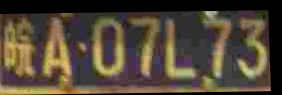

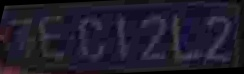

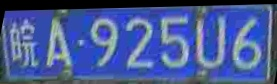

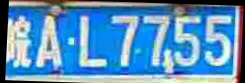

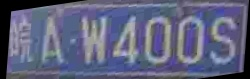

In [66]:
import os

files = os.listdir(f'{ROOT}/train')
    
for filename in np.array(files)[np.random.randint(0, len(files), 5).tolist()]:
        
    display(Image.open(f'{ROOT}/train/{filename}', ).convert('RGB'))

> Это датасет китайских номеров. Первый символ означает провинцую и пишется иероглифом, второй - город и обозначается латинскими буквами, остальные символы - это номер и они могу быть как цифрами, так и латинскими буквами.

In [67]:
state_symbols = ['皖', '沪', '津', '渝', '冀', '晋', '蒙', '辽', '吉', '黑', '苏', '浙', '京', '闽', '赣', '鲁', '豫', '鄂', '湘', '粤', '桂', '琼', '川', '贵', '云', '藏', '陕', '甘', '青', '宁', '新', '警', '学', 'O']
state_symbols_invert = dict(list(zip(range(len(state_symbols)), state_symbols)))
state_symbols = dict(list(zip(state_symbols, range(len(state_symbols)))))

city_symbols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
city_symbols_invert = dict(list(zip(range(len(city_symbols)), city_symbols)))
city_symbols = dict(list(zip(city_symbols, range(len(city_symbols)))))

number_symbols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']
number_symbols_invert = dict(list(zip(range(len(number_symbols)), number_symbols)))
number_symbols = dict(list(zip(number_symbols, range(len(number_symbols)))))

> Исходя из приведённых выше картинок можно сделать вывод, что все номера представляют собой белый текст на синем фоне, значит можно без потери содержания перевести их в чёрно-белые картнки и сэкономить память. 

In [68]:
transformer = T.Compose([T.Grayscale(1),
                         T.Resize((100, 400))])

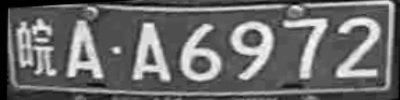

In [69]:
transformer(Image.open(f'{ROOT}/train/{files[0]}', ).convert('RGB'))

> Разделим тренировочный датасет на тренировочную и валидационную выборки.

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
train_files, valid_files = train_test_split(files, test_size=0.2, random_state=42)

> Создадим класс датасета

In [72]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, root, files, transformer, aug_number=None) -> None:
        super().__init__()

        self.root = root
        self.files = files

        self.transformer = transformer

        if aug_number is not None:

            aug_files = self.files.copy()

            for i in range(aug_number): aug_files.extend(self.files)

            self.files = aug_files

    
    def __len__(self):

        return len(self.files)

    
    def __getitem__(self, index):

        img = self.transformer(Image.open(f'{self.root}/{self.files[index]}', ).convert('RGB')).float()
        label = self.files[index].split('-')[1].replace('.jpg', '')

        state = state_symbols[label[0]]
        city = city_symbols[label[1]]
        number = [number_symbols[symbol] for symbol in label[2:]]

        return img, (state, city, number)

> Создадим тренировочный датасет, добавим к изначальному трансформеру немного агмунтаций (яркость, контраст, перспектива и другие). Не будем испоьзовать аугментации связанные с цвето (так как картинки будут чёрно-белыми).

In [73]:
train_transformer = T.Compose([transformer,
                               T.GaussianBlur(kernel_size=(5, 5), sigma=(0.001, 3)),
                               T.RandomAffine(degrees=0, scale=(0.8, 1), translate=(0.05, 0.05)),
                               T.RandomPerspective(distortion_scale=0.3),
                               T.ColorJitter(brightness=0.5, contrast=0.5)])

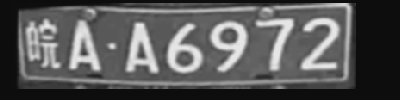

In [74]:
train_transformer(Image.open(f'{ROOT}/train/{files[0]}', ).convert('RGB'))

In [75]:
train_transformer.transforms.append(T.PILToTensor())

In [76]:
train_dataset = Dataset(f'{ROOT}/train', train_files, train_transformer, aug_number=2)

> Создадим валидационный и тестовый датасеты.

In [77]:
valid_transformer = T.Compose([transformer,
                               T.PILToTensor()])

In [78]:
valid_dataset = Dataset(f'{ROOT}/train', valid_files, valid_transformer)
test_dataset = Dataset(f'{ROOT}/test', os.listdir(f'{ROOT}/test'), valid_transformer)

> Создадим загрузчики

In [79]:
bs = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs, shuffle=False, drop_last=False)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False, drop_last=False)

## Создание и обучение модели

In [81]:
if torch.cuda.is_available(): DEVICE = 'cuda'
elif torch.backends.mps.is_available(): DEVICE = 'mps'
else: DEVICE = 'cpu'

DEVICE

'mps'

> Сначала напишем сверточный features-extractor. Для этого реализуем модель типа ResNet, чтобы избежать затухания градиента. На выходе будем получать семь векторов (соответственно на каждый символ номера), длинну которых будем задавать с помощью параметра embeded_dim.

In [82]:
class ResNet(torch.nn.Module):

    def __init__(self, embed_dim=512) -> None:
        super().__init__()

        self.activation = torch.nn.LeakyReLU()
        self.embed_dim = embed_dim

        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2, stride=(1, 2))
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 4))
        self.norm1 = torch.nn.BatchNorm2d(num_features=32)

        self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                         torch.nn.BatchNorm2d(32),
                                         self.activation,
                                         torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
                                         )
        self.norm2 = torch.nn.BatchNorm2d(num_features=32)

        self.conv3 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                         torch.nn.BatchNorm2d(32),
                                         self.activation,
                                         torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
                                         )
        self.norm3 = torch.nn.BatchNorm2d(num_features=32)

        self.conv_extra_size1 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=2)
        self.conv4 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=2),
                                         torch.nn.BatchNorm2d(64),
                                         self.activation,
                                         torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
                                         )
        self.norm4 = torch.nn.BatchNorm2d(num_features=64)

        self.conv5 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                         torch.nn.BatchNorm2d(64),
                                         self.activation,
                                         torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
                                         )
        self.norm5 = torch.nn.BatchNorm2d(num_features=64)

        self.conv_extra_size2 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=2)
        self.conv6 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=2),
                                         torch.nn.BatchNorm2d(128),
                                         self.activation,
                                         torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
                                         )
        self.norm6 = torch.nn.BatchNorm2d(num_features=128)

        self.conv7 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         torch.nn.BatchNorm2d(128),
                                         self.activation,
                                         torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
                                         )
        self.norm7 = torch.nn.BatchNorm2d(num_features=128)

        self.conv_extra_size3 = torch.nn.Conv2d(in_channels=128, out_channels=192, kernel_size=1, stride=2)
        self.conv8 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=128, out_channels=192, kernel_size=3, padding=1, stride=2),
                                         torch.nn.BatchNorm2d(192),
                                         self.activation,
                                         torch.nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding=1)
                                         )
        self.norm8 = torch.nn.BatchNorm2d(num_features=192)

        self.conv9 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding=1),
                                         torch.nn.BatchNorm2d(192),
                                         self.activation,
                                         torch.nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding=1)
                                         )
        self.norm9 = torch.nn.BatchNorm2d(num_features=192)

        self.conv_extra_size4 = torch.nn.Conv2d(in_channels=192, out_channels=192, kernel_size=1, stride=2)
        self.conv10 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding=1, stride=2),
                                          torch.nn.BatchNorm2d(192),
                                          self.activation,
                                          torch.nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding=1)
                                          )
        self.norm10 = torch.nn.BatchNorm2d(num_features=192)

        self.conv_extra_size5 = torch.nn.Conv2d(in_channels=192, out_channels=192, kernel_size=1, stride=2)
        self.conv11 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding=1, stride=2),
                                          torch.nn.BatchNorm2d(192),
                                          self.activation,
                                          torch.nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding=1)
                                          )
        self.norm11 = torch.nn.BatchNorm2d(num_features=192)

        self.head = torch.nn.Sequential(torch.nn.Flatten(),
                                        torch.nn.Dropout(0.2),
                                        torch.nn.Linear(3072, 7 * embed_dim))


    def forward(self, x):

        x = self.conv1(x)
        x = self.pool1(x)
        x = self.norm1(x)
        x = self.activation(x)

        x = self.conv2(x) + x
        x = self.norm2(x)
        x = self.activation(x)

        x = self.conv3(x) + x
        x = self.norm3(x)
        x = self.activation(x)

        x = self.conv4(x) + self.conv_extra_size1(x)
        x = self.norm4(x)
        x = self.activation(x)

        x = self.conv5(x) + x
        x = self.norm5(x)
        x = self.activation(x)

        x = self.conv6(x) + self.conv_extra_size2(x)
        x = self.norm6(x)
        x = self.activation(x)

        x = self.conv7(x) + x
        x = self.norm7(x)
        x = self.activation(x)

        x = self.conv8(x) + self.conv_extra_size3(x)
        x = self.norm8(x)
        x = self.activation(x)

        x = self.conv9(x) + x
        x = self.norm9(x)
        x = self.activation(x)

        x = self.conv10(x) + self.conv_extra_size4(x)
        x = self.norm10(x)
        x = self.activation(x)

        x = self.head(x)

        return x.reshape(-1, 7, self.embed_dim)

> Для дальнейшего обучения реализуем трансформер. Для этого воспользуемся модулем MultiheadAttention и добавим два линейных слоя полсе него. 

In [83]:
class TransformerLayer(torch.nn.Module):

    def __init__(self, embed_dim=512) -> None:
        super().__init__()

        self.attention = torch.nn.MultiheadAttention(embed_dim=embed_dim, num_heads=8, dropout=0.2, batch_first=True)
        self.norm1 = torch.nn.LayerNorm([7, embed_dim])

        self.head = torch.nn.Sequential(torch.nn.Linear(embed_dim, 4 * embed_dim),
                                        torch.nn.LeakyReLU(),
                                        torch.nn.Linear(4 * embed_dim, embed_dim))
        self.norm2 = torch.nn.LayerNorm([7, embed_dim])

    
    def forward(self, x):

        x = self.norm1(self.attention(x, x, x, need_weights=False)[0] + x)
        x = self.norm2(self.head(x) + x)
        
        return x

In [84]:
class Transformer(torch.nn.Module):

    def __init__(self, embed_dim=512) -> None:
        super().__init__()

        self.transformer_layer1 = TransformerLayer(embed_dim=embed_dim)
        self.transformer_layer2 = TransformerLayer(embed_dim=embed_dim)
        self.transformer_layer3 = TransformerLayer(embed_dim=embed_dim)

        
    def forward(self, x):

        x = self.transformer_layer1(x)
        x = self.transformer_layer2(x)
        x = self.transformer_layer3(x)

        return x

> Обернём все предыдущие классы в класс модели, которая будет возвращать вероятности отдельно для региона, города и номера. Для этого реализуем соответственно три линейных слоя, которые будут обрабатывать поступившие из трансформера векторы. Отдельная обработка этих трёх случаев связанна с тем, что для каждому из них соответствуют разные наборы символов и лучше в финальной части фокусироваться на специфичные признаки для каждой группы (как, например, мы меняем голову у предобученной модели, заставля её фокусироваться на важных для нашего случая признаках).

In [ ]:
class Model(torch.nn.Module):
    
    def __init__(self, embed_dim=512) -> None:
        super().__init__()

        self.resnet = ResNet(embed_dim=embed_dim)
        self.transformer = Transformer(embed_dim=embed_dim)

        def create_head(num_classes):

            head = torch.nn.Sequential(torch.nn.Linear(embed_dim, 2 * embed_dim),
                                       torch.nn.LayerNorm(2 * embed_dim),
                                       torch.nn.LeakyReLU(),
                                       torch.nn.Linear(2 * embed_dim, embed_dim),
                                       torch.nn.LayerNorm(embed_dim),
                                       torch.nn.LeakyReLU(),
                                       torch.nn.Linear(embed_dim, num_classes))

            return head

        self.state_head = create_head(len(state_symbols))
        self.city_head = create_head(len(city_symbols))
        self.number_head = create_head(len(number_symbols))
    
    def forward(self, x):

        x = self.resnet(x)
        x = self.transformer(x)

        state = x[:, 0, :]
        state = self.state_head(state)

        city = x[:, 1, :]
        city = self.city_head(city)

        number = x[:, 2:, :]
        number = self.number_head(number)

        return state, city, number

In [86]:
model = Model(embed_dim=64)
model.to(DEVICE);

In [87]:
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {num_parameters} trainable parameters")

Model has 4931358 trainable parameters


> Создадим train loop

In [88]:
from tqdm import tqdm
import telegram

TOKEN = '5871858475:AAHVcAQxxc3QwAPeSkk6MGxL9dCDIZmLoJs'
chat_id = '966066241'

bot = telegram.Bot(token=TOKEN)

In [89]:
class ModelTrainer():

    def __init__(self, model, optimizer, criterion, train_dataloader, valid_dataloader, epochs=10):

        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.85)
        
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader

        self.epochs = epochs

        self.verbose = 10
        self.verbose_step = round(self.verbose * (len(train_dataloader.dataset) // train_dataloader.batch_size) / 100)

    
    def train_mode(self, epoch):

        epoch_loss = []

        self.model.train()

        i = 0

        try:

            progress_bar = '⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️'
            message_text = f'Epoch {epoch}: {progress_bar} {i}/{len(self.train_dataloader.dataset) // self.train_dataloader.batch_size}'
            bot = telegram.Bot(token=TOKEN)
            message = bot.send_message(chat_id=chat_id, text=message_text)

        except Exception: pass

        for x, y in tqdm(self.train_dataloader, desc=f'Epoch {epoch} train'):

            x = x.to(DEVICE)

            self.optimizer.zero_grad()

            output = self.model(x)

            loss = self.criterion(output, y)

            loss.backward()

            self.optimizer.step()

            epoch_loss.append(loss.cpu().item())

            i += 1

            if i % self.verbose_step == 0:

                try:

                    progress_bar = progress_bar.replace('⬜️', '🟩', 1)
                    message_text = f'Epoch {epoch}: {progress_bar} {i}/{len(self.train_dataloader.dataset) // self.train_dataloader.batch_size}'
                    bot = telegram.Bot(token=TOKEN)
                    bot.edit_message_text(chat_id=chat_id, text=message_text, message_id=message.message_id)

                except Exception: pass

            else:

                try:

                    message_text = f'Epoch {epoch}: {progress_bar} {i}/{len(self.train_dataloader.dataset) // self.train_dataloader.batch_size}'
                    bot = telegram.Bot(token=TOKEN)
                    bot.edit_message_text(chat_id=chat_id, text=message_text, message_id=message.message_id)

                except Exception: pass

        try:

            if progress_bar != '🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩':
            
                progress_bar = '🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩'
                message_text = f'Epoch {epoch}: {progress_bar} {i}/{len(self.train_dataloader.dataset) // self.train_dataloader.batch_size}'
                bot = telegram.Bot(token=TOKEN)
                bot.edit_message_text(chat_id=chat_id, text=message_text, message_id=message.message_id)

        except Exception: pass

        self.lr_scheduler.step()

        return epoch_loss


    def val_mode(self, epoch):

        epoch_loss = []

        self.model.eval()

        with torch.no_grad():

            for x, y in tqdm(self.valid_dataloader, desc=f'Epoch {epoch} validation'):

                x = x.to(DEVICE)

                output = self.model(x)

                loss = self.criterion(output, y)

                epoch_loss.append(loss.cpu().item())

        return epoch_loss


    def train(self):

        min_val_loss = -1

        train_loss = []
        val_loss = []

        try:

            message = f'Train process has started and will last for {self.epochs} epochs'
            bot = telegram.Bot(token=TOKEN)
            bot.send_message(chat_id=chat_id, text=message)
            bot.send_message(chat_id=chat_id, text='🤡')

        except Exception: pass

        for epoch in range(self.epochs):

            train_loss.append(self.train_mode(epoch))
            print(f'train_loss: {np.mean(train_loss[-1])}')

            try:

                message = f'Epoch {epoch} train_loss: {np.mean(train_loss[-1])}'
                bot = telegram.Bot(token=TOKEN)
                bot.send_message(chat_id=chat_id, text=message)

            except Exception: pass

            val_loss.append(self.val_mode(epoch))
            print(f'valid_loss: {np.mean(val_loss[-1])}')

            example = {'true': [], 'pred': []}

            for i in range(5):

                true_state = state_symbols_invert[valid_dataset[i][1][0]]
                true_city = city_symbols_invert[valid_dataset[i][1][1]]
                true_number = ''.join([number_symbols_invert[valid_dataset[i][1][2][k]] for k in range(5)])
                true = f'{true_state}{true_city}{true_number}'

                output = model(valid_dataset[i][0].unsqueeze(0).to(DEVICE))

                pred_state = state_symbols_invert[output[0].detach().cpu().argmax().item()]
                pred_city = city_symbols_invert[output[1].detach().cpu().argmax().item()]
                pred_number = ''.join([number_symbols_invert[output[2].detach().cpu().argmax(dim=2).flatten()[k].item()] for k in range(5)])

                pred = f'{pred_state}{pred_city}{pred_number}'

                example['true'].append(true)
                example['pred'].append(pred)

            display(pd.DataFrame(example))
            
            try:

                message = f'Epoch {epoch} valid_loss: {np.mean(val_loss[-1])}'
                bot = telegram.Bot(token=TOKEN)
                bot.send_message(chat_id=chat_id, text=message)

            except Exception: pass

            if (np.mean(val_loss[-1]) < min_val_loss) or (min_val_loss == -1):

                min_val_loss = np.mean(val_loss[-1])
                torch.save(self.model.state_dict(), f'models/model.pr')

                try:
                    
                    pass
                    bot = telegram.Bot(token=TOKEN)
                    bot.send_message(chat_id=chat_id, text='😎')

                except Exception: pass

            else: 

                try: 

                    pass
                    bot = telegram.Bot(token=TOKEN)
                    bot.send_message(chat_id=chat_id, text='🤬')
                    
                except Exception: pass

        try:

            message = 'Train process has finished'
            bot = telegram.Bot(token=TOKEN)
            bot.send_message(chat_id=chat_id, text=message)
            bot.send_message(chat_id=chat_id, text='🥳')

        except Exception: pass

        return train_loss, val_loss

In [90]:
def criterion(y_preds, y_true):

    cr = torch.nn.CrossEntropyLoss()

    state_loss = cr(y_preds[0], y_true[0].to(DEVICE))
    city_loss = cr(y_preds[1], y_true[1].to(DEVICE))

    loss = state_loss + city_loss

    for i in range(5):

        number_loss = cr(y_preds[2][:, i, :], y_true[2][i].to(DEVICE))
        loss += number_loss

    return loss

In [91]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)

In [92]:
trainer = ModelTrainer(model, optimizer, criterion, train_dataloader, valid_dataloader, epochs=10)

In [93]:
try: train_loss, valid_loss = trainer.train()

except Exception as ex:

    try:

        message = f'Train process has crashed. An exception of type {type(ex).__name__} occured'
        print(message)
        bot = telegram.Bot(token=TOKEN)
        bot.send_message(chat_id=chat_id, text=message)
        bot.send_message(chat_id=chat_id, text='⚰️')

    except Exception: pass

except KeyboardInterrupt:

    try:

        message = f'Train process has been iterrupted'
        print(message)
        bot = telegram.Bot(token=TOKEN)
        bot.send_message(chat_id=chat_id, text=message)
        bot.send_message(chat_id=chat_id, text='❌')

    except Exception: pass

Epoch 0 train: 100%|██████████| 7499/7499 [33:35<00:00,  3.72it/s]


train_loss: 2.2589922395432604


Epoch 0 validation: 100%|██████████| 625/625 [00:49<00:00, 12.59it/s]


valid_loss: 0.423715990114212


,true,pred
0,皖AHT169,皖AHT169
1,皖AZ6Z66,皖AZ6Z66
2,苏E9Y38K,苏E9Y38K
3,皖AB5H66,皖AB5H66
4,皖AM877S,皖AM877S


Epoch 1 train: 100%|██████████| 7499/7499 [33:58<00:00,  3.68it/s]


train_loss: 0.2829615463873918


Epoch 1 validation: 100%|██████████| 625/625 [00:48<00:00, 12.77it/s]

valid_loss: 0.14589248601794244


,true,pred
0,皖AHT169,皖AH7169
1,皖AZ6Z66,皖AZ6Z66
2,苏E9Y38K,苏E9Y38K
3,皖AB5H66,皖AB5H66
4,皖AM877S,皖AM877S


Epoch 2 train: 100%|██████████| 7499/7499 [34:38<00:00,  3.61it/s]


train_loss: 0.2140236048508251


Epoch 2 validation: 100%|██████████| 625/625 [00:48<00:00, 12.76it/s]

valid_loss: 0.11238423064053059


,true,pred
0,皖AHT169,皖AHT169
1,皖AZ6Z66,皖AZ6Z66
2,苏E9Y38K,苏E9Y38K
3,皖AB5H66,皖AB5H66
4,皖AM877S,皖AM877S


Epoch 3 train: 100%|██████████| 7499/7499 [33:59<00:00,  3.68it/s]


train_loss: 0.180120991927685


Epoch 3 validation: 100%|██████████| 625/625 [00:48<00:00, 12.81it/s]

valid_loss: 0.13274184094667435


,true,pred
0,皖AHT169,皖AHT169
1,皖AZ6Z66,皖AZ6Z66
2,苏E9Y38K,苏E9Y38K
3,皖AB5H66,皖AB5H66
4,皖AM877S,皖AM877S


Epoch 4 train: 100%|██████████| 7499/7499 [35:07<00:00,  3.56it/s]


train_loss: 0.16122086330265173


Epoch 4 validation: 100%|██████████| 625/625 [00:49<00:00, 12.54it/s]

valid_loss: 0.11116011378616095


,true,pred
0,皖AHT169,皖AHT169
1,皖AZ6Z66,皖AZ6Z66
2,苏E9Y38K,苏E9Y38K
3,皖AB5H66,皖AB5H66
4,皖AM877S,皖AM877S


Epoch 5 train: 100%|██████████| 7499/7499 [34:31<00:00,  3.62it/s]


train_loss: 0.14123362232238582


Epoch 5 validation: 100%|██████████| 625/625 [00:50<00:00, 12.37it/s]

valid_loss: 0.08896941626816988


,true,pred
0,皖AHT169,皖AHT169
1,皖AZ6Z66,皖AZ6Z66
2,苏E9Y38K,苏E9Y38K
3,皖AB5H66,皖AB5H66
4,皖AM877S,皖AM877S


Epoch 6 train: 100%|██████████| 7499/7499 [35:05<00:00,  3.56it/s]


train_loss: 0.1290360257703404


Epoch 6 validation: 100%|██████████| 625/625 [00:49<00:00, 12.72it/s]

valid_loss: 0.07503234300762415


,true,pred
0,皖AHT169,皖AHT169
1,皖AZ6Z66,皖AZ6Z66
2,苏E9Y38K,苏E9Y38K
3,皖AB5H66,皖AB5H66
4,皖AM877S,皖AM877S


Epoch 7 train: 100%|██████████| 7499/7499 [35:00<00:00,  3.57it/s]


train_loss: 0.11767542648601967


Epoch 7 validation: 100%|██████████| 625/625 [00:50<00:00, 12.42it/s]

valid_loss: 0.08897089031934738


,true,pred
0,皖AHT169,皖AHT169
1,皖AZ6Z66,皖AZ6Z66
2,苏E9Y38K,苏E9Y38K
3,皖AB5H66,皖AB5H66
4,皖AM877S,皖AM877S


Epoch 8 train: 100%|██████████| 7499/7499 [34:38<00:00,  3.61it/s]


train_loss: 0.1104456599743284


Epoch 8 validation: 100%|██████████| 625/625 [00:50<00:00, 12.37it/s]


valid_loss: 0.05857000536471605


,true,pred
0,皖AHT169,皖AHT169
1,皖AZ6Z66,皖AZ6Z66
2,苏E9Y38K,苏E9Y38K
3,皖AB5H66,皖AB5H66
4,皖AM877S,皖AM877S


Epoch 9 train: 100%|██████████| 7499/7499 [35:08<00:00,  3.56it/s]


train_loss: 0.10241426216893704


Epoch 9 validation: 100%|██████████| 625/625 [00:50<00:00, 12.36it/s]


valid_loss: 0.07365798726081849


,true,pred
0,皖AHT169,皖AHT169
1,皖AZ6Z66,皖AZ6Z66
2,苏E9Y38K,苏E9Y38K
3,皖AB5H66,皖AB5H66
4,皖AM877S,皖AM877S


In [95]:
train_loss = np.array(train_loss)
valid_loss = np.array(valid_loss)

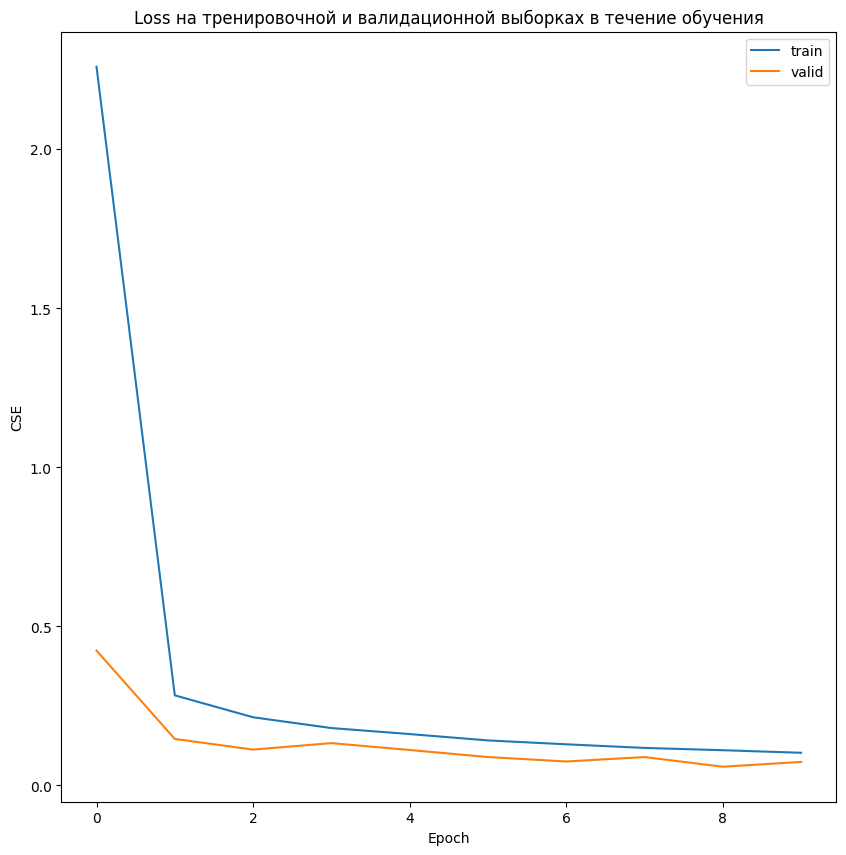

In [100]:
plt.figure(figsize=(10, 10))

plt.plot(train_loss.mean(axis=1), label='train')
plt.plot(valid_loss.mean(axis=1), label='valid')

plt.legend()

plt.title('Loss на тренировочной и валидационной выборках в течение обучения')

plt.xlabel('Epoch')
plt.ylabel('CSE')

plt.show()

> Исходя из графика лосса можно сделать вывод, что модель не переобучилась после 10 эпох, и можно было попробавать поучить её подольше для лучшего результата.

## Подсчёт метрик

> Загрузим лучшую модель и посмотрим метрики качества на тестовой выборке.

In [101]:
best_model = Model(embed_dim=64).to(DEVICE)
best_model.load_state_dict(torch.load('models/model.pr'))
best_model.eval();

In [102]:
from torchmetrics import CharErrorRate

In [103]:
def count_metrics(dataset, model):

    model.eval()

    with torch.no_grad():

        preds = []
        trues = []

        acc = 0
        cer = CharErrorRate()

        for x, y in tqdm(dataset):

            y = np.concatenate(([y[0]], [y[1]], y[2]))

            output = model(x.unsqueeze(0).to(DEVICE))

            pred_state = output[0].detach().cpu().argmax().item()
            pred_city = output[1].detach().cpu().argmax().item()
            pred_number = [output[2].detach().cpu().argmax(dim=2).flatten()[k].item() for k in range(5)]

            pred = np.concatenate(([pred_state], [pred_city], pred_number))

            if (pred == y).all(): acc += 1

            preds.append(pred)
            trues.append(y)

    return acc / len(dataset), cer(preds, trues).item(), preds

In [104]:
acc, cer, preds = count_metrics(test_dataset, best_model)

100%|██████████| 9999/9999 [02:56<00:00, 56.75it/s]


In [106]:
print(f'Accuracy on test {acc}')
print(f'CER on test {cer}')

Accuracy on test 0.9598959895989599
CER on test 0.006714957300573587


## Анализ ошибок

In [141]:
def found_worst(dataset):

    cer = []

    metric = CharErrorRate()

    i = 0

    for x, y in tqdm(dataset):

        y = np.concatenate(([y[0]], [y[1]], y[2]))

        cer.append(metric([y], [preds[i]]).item())

        i += 1

    return np.array(cer)#

In [142]:
cer = found_worst(test_dataset)
cer_worst = cer.argsort()[-9:]

100%|██████████| 9999/9999 [00:05<00:00, 1773.65it/s]


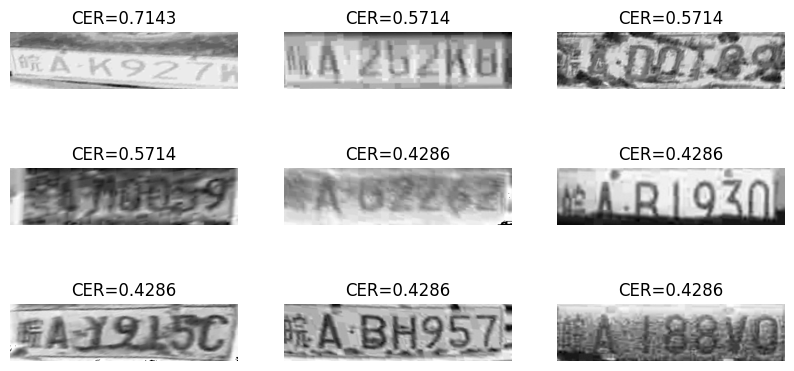

In [188]:
plt.figure(figsize=(10, 5))

for num, val in enumerate(cer_worst[::-1]):

    plt.subplot(3, 3, num + 1)
    plt.imshow(T.ToPILImage()(test_dataset[val][0]), cmap='gray')
    plt.axis('off')
    plt.title(f'CER={cer[val]:.4}')

> Как видно, ошибки возникли на номерах, которые при трансформации которых в чёрно-белые изображения цевт таблички и цвет номера инвертировались по отношению к большинству других номеров. Значит, для улучшения работы сети, стоит оставлять все три канала изображения или добавить аугментацию инвертирования цветов. Также на плохую работу алгоритма на данных примерах могло повлиять плохое качество фотографий, возможно, стоит добваить больше аугментаци и сделать их более выраженными.